In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
#from Inference.GeNVI_method import GeNVariationalInference, GeNetEns
from Inference.GeNVI_predictive import GeNPredVI, GeNetEns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)


# Target density #

In [4]:
logprior=setup.logPredPrior
loglikelihood=setup.loglikelihood
projection=setup.projection
size_sample=setup.n_train_samples
param_count=setup.param_count
model=setup._model

size_sample

200

# GeNVI #

In [5]:
activation = nn.Tanh()#nn.ReLU()
init_b = .001

GeN = GeNetEns(1, 2, 50, param_count, activation, 0.2, init_b, device)

In [6]:
from Tools import logmvn01pdf

x=torch.arange(-3.,3., 0.05).to(device)

grid_X,grid_Y=torch.meshgrid(x, x)
colors=torch.Tensor(grid_X.shape)

for i in range(colors.shape[0]):
    for j in range(colors.shape[1]):
        xy=torch.Tensor([grid_X[i,j],grid_Y[i,j]]).unsqueeze(0).to(device)
        colors[i,j]=logmvn01pdf(xy,device).exp().cpu()


In [7]:
noise=(grid_X.cpu().numpy(),grid_Y.cpu().numpy(),colors.cpu().numpy())

-10.837877 -1.8378772


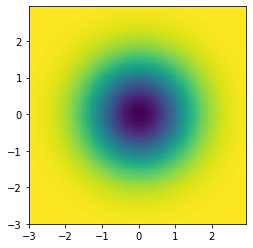

In [8]:
%matplotlib inline
import matplotlib.cm as cm

cmap = cm.viridis_r

plt.pcolormesh(noise[0],noise[1],noise[2],cmap=cmap)
plt.axis('scaled')
#plt.title('Gaussian noise')

print(np.log(noise[2].min()),np.log(noise[2].max()))
plt.savefig('noise.pdf')

In [9]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm



%matplotlib inline



def makePlot(self, GeN,noise, alpha=0.05 ,device=device):
    def get_linewidth(linewidth, axis):
        fig = axis.get_figure()
        ppi = 72  # matplolib points per inches
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())[0]
        return linewidth * ppi * length / value_range
#    nb_samples_plot=theta.shape[0]
    x_lin = torch.linspace(-2.0, 2.0).unsqueeze(1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.xlim(-2, 2) 
    plt.ylim(-3, 4.5)
    plt.grid(True, which='major', linewidth=0.5)
    my_lw=get_linewidth(0.2,ax)
#    alpha = (.9 / torch.tensor(float(nb_samples_plot)).sqrt()).clamp(0.05, 1.)
    
    colors=noise[2]
    
    norm=Normalize(vmin=colors.min(), vmax=colors.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            xy_noise=torch.Tensor([noise[0][i,j],noise[1][i,j]]).unsqueeze(0).to(device)
            theta=GeN.components[0].hnet(xy_noise).detach()
            y_pred = self._normalized_prediction(x_lin, theta, device)
            color=m.to_rgba(colors[i,j])
            alpha_=alpha*(11+np.log(colors[i,j]))/9
            plt.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), alpha=alpha_, linewidth=1.0, color=color,zorder=3)
    plt.scatter(self._X_train.cpu(), self._y_train.cpu(), marker='.',color='black',zorder=4)
    return fig



In [10]:
%matplotlib inline
from tempfile import TemporaryDirectory

k_MC=300

def show(x,y):
    return

with TemporaryDirectory() as temp_dir:
    optimizer = GeNPredVI(loglikelihood, logprior, projection, k_MC,
		                                    0, 100, 1000, 50, 50,
		                                    20000, .01, .00001, 200, .5,
		                                    device, True, temp_dir, save_best=True)
    best_epoch, scores=optimizer.run(GeN,show)
#    optimizer = GeNVariationalInference(logtarget,
#		                                    1, 100, 1000, 50, 100,
#		                                    20000, .01, .000001, 500, .5,
#		                                    device, True, temp_dir, save_best=True)
#    best_epoch, scores=optimizer.run(GeN)
print(best_epoch)

Epoch [0/20000], Loss: 25093.78125, Entropy -1123.53857421875, Learning Rate: 0.01
Epoch [1/20000], Loss: 366279.9375, Entropy -939.3833618164062, Learning Rate: 0.01
Epoch [2/20000], Loss: 128311.4375, Entropy -956.4891967773438, Learning Rate: 0.01
Epoch [3/20000], Loss: 75843.0390625, Entropy -1012.2445678710938, Learning Rate: 0.01
Epoch [4/20000], Loss: 31589.732421875, Entropy -972.8993530273438, Learning Rate: 0.01
Epoch [5/20000], Loss: 72078.8671875, Entropy -1070.0677490234375, Learning Rate: 0.01
Epoch [6/20000], Loss: 40427.3671875, Entropy -1046.352783203125, Learning Rate: 0.01
Epoch [7/20000], Loss: 31353.353515625, Entropy -984.4170532226562, Learning Rate: 0.01
Epoch [8/20000], Loss: 21930.642578125, Entropy -1071.6685791015625, Learning Rate: 0.01
Epoch [9/20000], Loss: 11600.3427734375, Entropy -1179.869873046875, Learning Rate: 0.01
Epoch [10/20000], Loss: 29601.1328125, Entropy -1091.654052734375, Learning Rate: 0.01
Epoch [11/20000], Loss: 13419.384765625, Entropy

Epoch [113/20000], Loss: 2132.081298828125, Entropy -1254.2965087890625, Learning Rate: 0.01
Epoch [114/20000], Loss: 2130.830078125, Entropy -1274.843017578125, Learning Rate: 0.01
Epoch [115/20000], Loss: 2022.6160888671875, Entropy -1268.6270751953125, Learning Rate: 0.01
Epoch [116/20000], Loss: 2171.724365234375, Entropy -1292.5997314453125, Learning Rate: 0.01
Epoch [117/20000], Loss: 2056.215087890625, Entropy -1313.93505859375, Learning Rate: 0.01
Epoch [118/20000], Loss: 2202.72216796875, Entropy -1241.218017578125, Learning Rate: 0.01
Epoch [119/20000], Loss: 2106.83984375, Entropy -1290.57568359375, Learning Rate: 0.01
Epoch [120/20000], Loss: 2160.731689453125, Entropy -1270.763916015625, Learning Rate: 0.01
Epoch [121/20000], Loss: 2024.260498046875, Entropy -1259.821044921875, Learning Rate: 0.01
Epoch [122/20000], Loss: 1954.404296875, Entropy -1250.22509765625, Learning Rate: 0.01
Epoch [123/20000], Loss: 2096.111083984375, Entropy -1277.0955810546875, Learning Rate: 0.

Epoch [203/20000], Loss: 1785.0186767578125, Entropy -1189.76025390625, Learning Rate: 0.01
Epoch [204/20000], Loss: 1855.480224609375, Entropy -1198.4920654296875, Learning Rate: 0.01
Epoch [205/20000], Loss: 1795.8031005859375, Entropy -1244.84423828125, Learning Rate: 0.01
Epoch [206/20000], Loss: 1824.6019287109375, Entropy -1196.8829345703125, Learning Rate: 0.01
Epoch [207/20000], Loss: 1775.390625, Entropy -1172.100341796875, Learning Rate: 0.01
Epoch [208/20000], Loss: 1862.146728515625, Entropy -1194.4842529296875, Learning Rate: 0.01
Epoch [209/20000], Loss: 1813.8681640625, Entropy -1209.2581787109375, Learning Rate: 0.01
Epoch [210/20000], Loss: 1897.56396484375, Entropy -1232.5828857421875, Learning Rate: 0.01
Epoch [211/20000], Loss: 1732.845458984375, Entropy -1212.3319091796875, Learning Rate: 0.01
Epoch [212/20000], Loss: 1779.6502685546875, Entropy -1189.223876953125, Learning Rate: 0.01
Epoch [213/20000], Loss: 1757.203369140625, Entropy -1178.8465576171875, Learning

Epoch [293/20000], Loss: 1845.430419921875, Entropy -1152.85302734375, Learning Rate: 0.01
Epoch [294/20000], Loss: 1779.1993408203125, Entropy -1178.0286865234375, Learning Rate: 0.01
Epoch [295/20000], Loss: 1895.02734375, Entropy -1156.866455078125, Learning Rate: 0.01
Epoch [296/20000], Loss: 2236.083740234375, Entropy -1155.6871337890625, Learning Rate: 0.01
Epoch [297/20000], Loss: 1864.3873291015625, Entropy -1135.781005859375, Learning Rate: 0.01
Epoch [298/20000], Loss: 2532.2431640625, Entropy -1187.461669921875, Learning Rate: 0.01
Epoch [299/20000], Loss: 2195.30810546875, Entropy -1161.982177734375, Learning Rate: 0.01
Epoch [300/20000], Loss: 1911.7103271484375, Entropy -1181.9385986328125, Learning Rate: 0.01
Epoch [301/20000], Loss: 2268.960205078125, Entropy -1216.447021484375, Learning Rate: 0.01
Epoch [302/20000], Loss: 2066.203857421875, Entropy -1200.93603515625, Learning Rate: 0.01
Epoch [303/20000], Loss: 2008.3731689453125, Entropy -1168.98779296875, Learning Ra

Epoch [387/20000], Loss: 1648.8760986328125, Entropy -1172.0223388671875, Learning Rate: 0.01
Epoch [388/20000], Loss: 1671.591064453125, Entropy -1192.193115234375, Learning Rate: 0.01
Epoch [389/20000], Loss: 1749.657470703125, Entropy -1164.1539306640625, Learning Rate: 0.01
Epoch [390/20000], Loss: 1644.857177734375, Entropy -1176.642822265625, Learning Rate: 0.01
Epoch [391/20000], Loss: 1719.034912109375, Entropy -1172.9683837890625, Learning Rate: 0.01
Epoch [392/20000], Loss: 1755.698974609375, Entropy -1227.2489013671875, Learning Rate: 0.01
Epoch [393/20000], Loss: 1803.701416015625, Entropy -1149.0447998046875, Learning Rate: 0.01
Epoch [394/20000], Loss: 1711.39501953125, Entropy -1171.569580078125, Learning Rate: 0.01
Epoch [395/20000], Loss: 1876.7430419921875, Entropy -1144.611572265625, Learning Rate: 0.01
Epoch [396/20000], Loss: 1805.909423828125, Entropy -1162.0291748046875, Learning Rate: 0.01
Epoch [397/20000], Loss: 1900.977783203125, Entropy -1175.26806640625, Le

Epoch [477/20000], Loss: 1749.4951171875, Entropy -1158.226806640625, Learning Rate: 0.01
Epoch [478/20000], Loss: 1721.73876953125, Entropy -1120.2186279296875, Learning Rate: 0.01
Epoch [479/20000], Loss: 1557.50341796875, Entropy -1123.6768798828125, Learning Rate: 0.01
Epoch [480/20000], Loss: 1760.4599609375, Entropy -1163.03271484375, Learning Rate: 0.01
Epoch [481/20000], Loss: 1651.8662109375, Entropy -1177.408203125, Learning Rate: 0.01
Epoch [482/20000], Loss: 1673.317138671875, Entropy -1163.0701904296875, Learning Rate: 0.01
Epoch [483/20000], Loss: 1640.33203125, Entropy -1119.020263671875, Learning Rate: 0.01
Epoch [484/20000], Loss: 1633.0018310546875, Entropy -1167.235107421875, Learning Rate: 0.01
Epoch [485/20000], Loss: 1692.701416015625, Entropy -1099.77294921875, Learning Rate: 0.01
Epoch [486/20000], Loss: 1623.3232421875, Entropy -1112.287109375, Learning Rate: 0.01
Epoch [487/20000], Loss: 1556.7935791015625, Entropy -1105.9400634765625, Learning Rate: 0.01
Epoc

Epoch [569/20000], Loss: 1610.8878173828125, Entropy -1107.1126708984375, Learning Rate: 0.01
Epoch [570/20000], Loss: 2717.23095703125, Entropy -1159.83642578125, Learning Rate: 0.01
Epoch [571/20000], Loss: 2323.7509765625, Entropy -1129.253173828125, Learning Rate: 0.01
Epoch [572/20000], Loss: 2130.90673828125, Entropy -1107.5311279296875, Learning Rate: 0.01
Epoch [573/20000], Loss: 2352.6474609375, Entropy -1133.900390625, Learning Rate: 0.01
Epoch [574/20000], Loss: 2152.70068359375, Entropy -1136.2894287109375, Learning Rate: 0.01
Epoch [575/20000], Loss: 2039.05810546875, Entropy -1104.3463134765625, Learning Rate: 0.01
Epoch [576/20000], Loss: 2506.558837890625, Entropy -1137.302001953125, Learning Rate: 0.01
Epoch [577/20000], Loss: 1824.799072265625, Entropy -1125.3092041015625, Learning Rate: 0.01
Epoch [578/20000], Loss: 2382.920166015625, Entropy -1082.3411865234375, Learning Rate: 0.01
Epoch [579/20000], Loss: 1817.970703125, Entropy -1096.5517578125, Learning Rate: 0.0

Epoch [689/20000], Loss: 1518.7940673828125, Entropy -1099.5869140625, Learning Rate: 0.01
Epoch [690/20000], Loss: 1426.5234375, Entropy -1080.7301025390625, Learning Rate: 0.01
Epoch [691/20000], Loss: 1493.6981201171875, Entropy -1073.463134765625, Learning Rate: 0.01
Epoch [692/20000], Loss: 1528.6854248046875, Entropy -1121.438232421875, Learning Rate: 0.01
Epoch [693/20000], Loss: 1495.3876953125, Entropy -1104.01416015625, Learning Rate: 0.01
Epoch [694/20000], Loss: 1556.1007080078125, Entropy -1114.288818359375, Learning Rate: 0.01
Epoch [695/20000], Loss: 1499.1300048828125, Entropy -1107.769775390625, Learning Rate: 0.01
Epoch [696/20000], Loss: 1445.25146484375, Entropy -1104.23779296875, Learning Rate: 0.01
Epoch [697/20000], Loss: 1467.5234375, Entropy -1048.906982421875, Learning Rate: 0.01
Epoch [698/20000], Loss: 1478.24267578125, Entropy -1079.8848876953125, Learning Rate: 0.01
Epoch [699/20000], Loss: 1523.6158447265625, Entropy -1088.7557373046875, Learning Rate: 0.

Epoch [782/20000], Loss: 1631.340576171875, Entropy -1052.097900390625, Learning Rate: 0.01
Epoch [783/20000], Loss: 1528.240234375, Entropy -1094.77978515625, Learning Rate: 0.01
Epoch [784/20000], Loss: 1691.04541015625, Entropy -1092.7962646484375, Learning Rate: 0.01
Epoch [785/20000], Loss: 1511.7310791015625, Entropy -1116.059814453125, Learning Rate: 0.01
Epoch [786/20000], Loss: 1572.5169677734375, Entropy -1078.1212158203125, Learning Rate: 0.01
Epoch [787/20000], Loss: 1515.0751953125, Entropy -1068.010498046875, Learning Rate: 0.01
Epoch [788/20000], Loss: 1643.9014892578125, Entropy -1061.90283203125, Learning Rate: 0.01
Epoch [789/20000], Loss: 1518.5123291015625, Entropy -1092.01806640625, Learning Rate: 0.01
Epoch [790/20000], Loss: 1591.0302734375, Entropy -1050.951416015625, Learning Rate: 0.01
Epoch [791/20000], Loss: 1621.081298828125, Entropy -1050.037109375, Learning Rate: 0.01
Epoch [792/20000], Loss: 1604.1600341796875, Entropy -1096.640380859375, Learning Rate: 

Epoch [872/20000], Loss: 1429.984130859375, Entropy -1051.8486328125, Learning Rate: 0.01
Epoch [873/20000], Loss: 1416.1737060546875, Entropy -1048.659423828125, Learning Rate: 0.01
Epoch [874/20000], Loss: 1529.8079833984375, Entropy -1063.982421875, Learning Rate: 0.01
Epoch [875/20000], Loss: 1416.3084716796875, Entropy -1042.6385498046875, Learning Rate: 0.01
Epoch [876/20000], Loss: 1460.4857177734375, Entropy -1073.21875, Learning Rate: 0.01
Epoch [877/20000], Loss: 1453.6024169921875, Entropy -1037.8751220703125, Learning Rate: 0.01
Epoch [878/20000], Loss: 1447.2962646484375, Entropy -1068.3992919921875, Learning Rate: 0.01
Epoch [879/20000], Loss: 1471.690673828125, Entropy -1100.193603515625, Learning Rate: 0.01
Epoch [880/20000], Loss: 1432.4019775390625, Entropy -1058.2728271484375, Learning Rate: 0.01
Epoch [881/20000], Loss: 1413.154052734375, Entropy -1043.02392578125, Learning Rate: 0.01
Epoch [882/20000], Loss: 1470.5296630859375, Entropy -1031.56201171875, Learning R

Epoch [963/20000], Loss: 1535.350830078125, Entropy -1039.3314208984375, Learning Rate: 0.01
Epoch [964/20000], Loss: 1372.4581298828125, Entropy -1017.2230224609375, Learning Rate: 0.01
Epoch [965/20000], Loss: 1479.7088623046875, Entropy -1045.594970703125, Learning Rate: 0.01
Epoch [966/20000], Loss: 1519.1068115234375, Entropy -1064.19580078125, Learning Rate: 0.01
Epoch [967/20000], Loss: 1374.4781494140625, Entropy -1002.7684326171875, Learning Rate: 0.01
Epoch [968/20000], Loss: 1443.302734375, Entropy -985.2105712890625, Learning Rate: 0.01
Epoch [969/20000], Loss: 1464.1378173828125, Entropy -1021.865966796875, Learning Rate: 0.01
Epoch [970/20000], Loss: 1586.9368896484375, Entropy -1079.870849609375, Learning Rate: 0.01
Epoch [971/20000], Loss: 1386.0125732421875, Entropy -1029.836669921875, Learning Rate: 0.01
Epoch [972/20000], Loss: 1485.0396728515625, Entropy -1010.55126953125, Learning Rate: 0.01
Epoch [973/20000], Loss: 1501.6392822265625, Entropy -1038.9393310546875, 

Epoch [1056/20000], Loss: 1767.8231201171875, Entropy -1055.9674072265625, Learning Rate: 0.01
Epoch [1057/20000], Loss: 1452.9501953125, Entropy -1021.9524536132812, Learning Rate: 0.01
Epoch [1058/20000], Loss: 1572.4014892578125, Entropy -1029.7606201171875, Learning Rate: 0.01
Epoch [1059/20000], Loss: 1486.546142578125, Entropy -1026.93701171875, Learning Rate: 0.01
Epoch [1060/20000], Loss: 1537.266357421875, Entropy -1061.993896484375, Learning Rate: 0.01
Epoch [1061/20000], Loss: 1359.927001953125, Entropy -1011.6468505859375, Learning Rate: 0.01
Epoch [1062/20000], Loss: 1508.4451904296875, Entropy -1045.779052734375, Learning Rate: 0.01
Epoch [1063/20000], Loss: 1423.1064453125, Entropy -1012.0364990234375, Learning Rate: 0.01
Epoch [1064/20000], Loss: 1461.02294921875, Entropy -1046.594970703125, Learning Rate: 0.01
Epoch [1065/20000], Loss: 1506.1640625, Entropy -1048.89404296875, Learning Rate: 0.01
Epoch [1066/20000], Loss: 1466.46728515625, Entropy -1011.8380126953125, L

Epoch [1147/20000], Loss: 1362.98046875, Entropy -999.9419555664062, Learning Rate: 0.01
Epoch [1148/20000], Loss: 1379.9749755859375, Entropy -1053.893310546875, Learning Rate: 0.01
Epoch [1149/20000], Loss: 1303.5501708984375, Entropy -998.595703125, Learning Rate: 0.01
Epoch [1150/20000], Loss: 1355.5491943359375, Entropy -1030.8775634765625, Learning Rate: 0.01
Epoch [1151/20000], Loss: 1343.890380859375, Entropy -1012.4650268554688, Learning Rate: 0.01
Epoch [1152/20000], Loss: 1322.4705810546875, Entropy -987.2655639648438, Learning Rate: 0.01
Epoch [1153/20000], Loss: 1385.431884765625, Entropy -1011.9937744140625, Learning Rate: 0.01
Epoch [1154/20000], Loss: 1337.591796875, Entropy -1009.0296020507812, Learning Rate: 0.01
Epoch [1155/20000], Loss: 1298.167236328125, Entropy -992.7774658203125, Learning Rate: 0.01
Epoch [1156/20000], Loss: 1317.743896484375, Entropy -1005.7420654296875, Learning Rate: 0.01
Epoch [1157/20000], Loss: 1343.963623046875, Entropy -1028.1046142578125

Epoch [1239/20000], Loss: 1919.758544921875, Entropy -1003.0142211914062, Learning Rate: 0.01
Epoch [1240/20000], Loss: 1429.5364990234375, Entropy -955.1270141601562, Learning Rate: 0.01
Epoch [1241/20000], Loss: 1710.8558349609375, Entropy -982.0718994140625, Learning Rate: 0.01
Epoch [1242/20000], Loss: 1546.8773193359375, Entropy -1024.58935546875, Learning Rate: 0.01
Epoch [1243/20000], Loss: 1624.40625, Entropy -965.0640869140625, Learning Rate: 0.01
Epoch [1244/20000], Loss: 1687.6829833984375, Entropy -971.4808959960938, Learning Rate: 0.01
Epoch [1245/20000], Loss: 1677.8680419921875, Entropy -1013.4185791015625, Learning Rate: 0.01
Epoch [1246/20000], Loss: 1640.93798828125, Entropy -1021.389404296875, Learning Rate: 0.01
Epoch [1247/20000], Loss: 1480.5740966796875, Entropy -1001.243896484375, Learning Rate: 0.01
Epoch [1248/20000], Loss: 1653.134033203125, Entropy -1008.7968139648438, Learning Rate: 0.01
Epoch [1249/20000], Loss: 1420.111572265625, Entropy -1000.59124755859

Epoch [1330/20000], Loss: 1384.443603515625, Entropy -1047.07373046875, Learning Rate: 0.01
Epoch [1331/20000], Loss: 1310.458984375, Entropy -982.4609375, Learning Rate: 0.01
Epoch [1332/20000], Loss: 1316.9078369140625, Entropy -943.9267578125, Learning Rate: 0.01
Epoch [1333/20000], Loss: 1476.5059814453125, Entropy -1013.8975830078125, Learning Rate: 0.01
Epoch [1334/20000], Loss: 1348.138671875, Entropy -995.5669555664062, Learning Rate: 0.01
Epoch [1335/20000], Loss: 1341.4139404296875, Entropy -970.78515625, Learning Rate: 0.01
Epoch [1336/20000], Loss: 1319.5341796875, Entropy -981.3980712890625, Learning Rate: 0.01
Epoch [1337/20000], Loss: 1335.58251953125, Entropy -982.9292602539062, Learning Rate: 0.01
Epoch [1338/20000], Loss: 1346.248779296875, Entropy -990.744140625, Learning Rate: 0.01
Epoch [1339/20000], Loss: 1311.458740234375, Entropy -964.8942260742188, Learning Rate: 0.01
Epoch [1340/20000], Loss: 1324.5308837890625, Entropy -961.2089233398438, Learning Rate: 0.01


Epoch [1422/20000], Loss: 1552.340087890625, Entropy -1047.287353515625, Learning Rate: 0.01
Epoch [1423/20000], Loss: 1641.8321533203125, Entropy -1064.915283203125, Learning Rate: 0.01
Epoch [1424/20000], Loss: 1573.37744140625, Entropy -1017.2279052734375, Learning Rate: 0.01
Epoch [1425/20000], Loss: 1621.9244384765625, Entropy -1038.33642578125, Learning Rate: 0.01
Epoch [1426/20000], Loss: 1479.8245849609375, Entropy -1023.5316772460938, Learning Rate: 0.01
Epoch [1427/20000], Loss: 1731.1710205078125, Entropy -999.267578125, Learning Rate: 0.01
Epoch [1428/20000], Loss: 1548.860595703125, Entropy -1042.355712890625, Learning Rate: 0.01
Epoch [1429/20000], Loss: 1639.77197265625, Entropy -1012.1292114257812, Learning Rate: 0.01
Epoch [1430/20000], Loss: 1524.38818359375, Entropy -1039.246826171875, Learning Rate: 0.01
Epoch [1431/20000], Loss: 1637.5267333984375, Entropy -1064.4879150390625, Learning Rate: 0.01
Epoch [1432/20000], Loss: 1517.0360107421875, Entropy -1018.522827148

Epoch [1513/20000], Loss: 1253.6923828125, Entropy -937.8541259765625, Learning Rate: 0.01
Epoch [1514/20000], Loss: 1269.5546875, Entropy -928.491455078125, Learning Rate: 0.01
Epoch [1515/20000], Loss: 1278.8916015625, Entropy -974.5189819335938, Learning Rate: 0.01
Epoch [1516/20000], Loss: 1296.0029296875, Entropy -957.1173706054688, Learning Rate: 0.01
Epoch [1517/20000], Loss: 1352.308349609375, Entropy -949.3981323242188, Learning Rate: 0.01
Epoch [1518/20000], Loss: 1270.994140625, Entropy -954.8607177734375, Learning Rate: 0.01
Epoch [1519/20000], Loss: 1386.750244140625, Entropy -996.6234130859375, Learning Rate: 0.01
Epoch [1520/20000], Loss: 1348.750244140625, Entropy -956.752197265625, Learning Rate: 0.01
Epoch [1521/20000], Loss: 1351.495849609375, Entropy -943.27490234375, Learning Rate: 0.01
Epoch [1522/20000], Loss: 1309.8359375, Entropy -981.0155029296875, Learning Rate: 0.01
Epoch [1523/20000], Loss: 1331.380859375, Entropy -948.4615478515625, Learning Rate: 0.01
Epo

Epoch [1610/20000], Loss: 1197.568359375, Entropy -913.3051147460938, Learning Rate: 0.005
Epoch [1611/20000], Loss: 1226.26025390625, Entropy -948.9480590820312, Learning Rate: 0.005
Epoch [1612/20000], Loss: 1204.3963623046875, Entropy -921.0963134765625, Learning Rate: 0.005
Epoch [1613/20000], Loss: 1227.697509765625, Entropy -941.93603515625, Learning Rate: 0.005
Epoch [1614/20000], Loss: 1246.964599609375, Entropy -971.588134765625, Learning Rate: 0.005
Epoch [1615/20000], Loss: 1215.0137939453125, Entropy -929.701171875, Learning Rate: 0.005
Epoch [1616/20000], Loss: 1211.933349609375, Entropy -918.5195922851562, Learning Rate: 0.005
Epoch [1617/20000], Loss: 1241.2064208984375, Entropy -972.021240234375, Learning Rate: 0.005
Epoch [1618/20000], Loss: 1218.89794921875, Entropy -951.1619873046875, Learning Rate: 0.005
Epoch [1619/20000], Loss: 1204.93798828125, Entropy -935.301513671875, Learning Rate: 0.005
Epoch [1620/20000], Loss: 1223.417724609375, Entropy -926.1439819335938,

Epoch [1711/20000], Loss: 1182.40869140625, Entropy -907.684814453125, Learning Rate: 0.005
Epoch [1712/20000], Loss: 1203.5673828125, Entropy -931.6298828125, Learning Rate: 0.005
Epoch [1713/20000], Loss: 1185.8096923828125, Entropy -910.7096557617188, Learning Rate: 0.005
Epoch [1714/20000], Loss: 1159.676025390625, Entropy -883.6781616210938, Learning Rate: 0.005
Epoch [1715/20000], Loss: 1170.59423828125, Entropy -909.4200439453125, Learning Rate: 0.005
Epoch [1716/20000], Loss: 1145.06201171875, Entropy -862.720703125, Learning Rate: 0.005
Epoch [1717/20000], Loss: 1192.3173828125, Entropy -921.0077514648438, Learning Rate: 0.005
Epoch [1718/20000], Loss: 1174.5513916015625, Entropy -909.27978515625, Learning Rate: 0.005
Epoch [1719/20000], Loss: 1196.812744140625, Entropy -913.9822998046875, Learning Rate: 0.005
Epoch [1720/20000], Loss: 1162.6851806640625, Entropy -880.7689819335938, Learning Rate: 0.005
Epoch [1721/20000], Loss: 1214.6658935546875, Entropy -918.23095703125, Le

Epoch [1803/20000], Loss: 1202.9447021484375, Entropy -907.819580078125, Learning Rate: 0.005
Epoch [1804/20000], Loss: 1174.02783203125, Entropy -886.5597534179688, Learning Rate: 0.005
Epoch [1805/20000], Loss: 1160.544189453125, Entropy -883.136474609375, Learning Rate: 0.005
Epoch [1806/20000], Loss: 1140.997802734375, Entropy -866.7474975585938, Learning Rate: 0.005
Epoch [1807/20000], Loss: 1225.3775634765625, Entropy -943.715576171875, Learning Rate: 0.005
Epoch [1808/20000], Loss: 1169.2939453125, Entropy -889.731201171875, Learning Rate: 0.005
Epoch [1809/20000], Loss: 1242.8179931640625, Entropy -907.1306762695312, Learning Rate: 0.005
Epoch [1810/20000], Loss: 1199.576171875, Entropy -888.5945434570312, Learning Rate: 0.005
Epoch [1811/20000], Loss: 1198.23046875, Entropy -882.874267578125, Learning Rate: 0.005
Epoch [1812/20000], Loss: 1195.8475341796875, Entropy -899.115234375, Learning Rate: 0.005
Epoch [1813/20000], Loss: 1282.242431640625, Entropy -954.8528442382812, Le

Epoch [1895/20000], Loss: 1660.3310546875, Entropy -950.0676879882812, Learning Rate: 0.005
Epoch [1896/20000], Loss: 1294.27197265625, Entropy -931.83056640625, Learning Rate: 0.005
Epoch [1897/20000], Loss: 1621.2066650390625, Entropy -912.8658447265625, Learning Rate: 0.005
Epoch [1898/20000], Loss: 1219.0128173828125, Entropy -872.8678588867188, Learning Rate: 0.005
Epoch [1899/20000], Loss: 1527.912841796875, Entropy -901.1400756835938, Learning Rate: 0.005
Epoch [1900/20000], Loss: 1380.0350341796875, Entropy -919.154541015625, Learning Rate: 0.005
Epoch [1901/20000], Loss: 1594.7169189453125, Entropy -939.4216918945312, Learning Rate: 0.005
Epoch [1902/20000], Loss: 1461.7216796875, Entropy -906.4776611328125, Learning Rate: 0.005
Epoch [1903/20000], Loss: 1371.8359375, Entropy -962.058349609375, Learning Rate: 0.005
Epoch [1904/20000], Loss: 1488.0052490234375, Entropy -926.7096557617188, Learning Rate: 0.005
Epoch [1905/20000], Loss: 1508.595703125, Entropy -923.3778076171875,

Epoch [2009/20000], Loss: 1158.618408203125, Entropy -872.7821044921875, Learning Rate: 0.005
Epoch [2010/20000], Loss: 1169.997314453125, Entropy -890.518310546875, Learning Rate: 0.005
Epoch [2011/20000], Loss: 1142.0859375, Entropy -864.8701171875, Learning Rate: 0.005
Epoch [2012/20000], Loss: 1183.921630859375, Entropy -907.5040283203125, Learning Rate: 0.005
Epoch [2013/20000], Loss: 1157.8408203125, Entropy -878.5955810546875, Learning Rate: 0.005
Epoch [2014/20000], Loss: 1216.1890869140625, Entropy -912.4193725585938, Learning Rate: 0.005
Epoch [2015/20000], Loss: 1162.59716796875, Entropy -887.642333984375, Learning Rate: 0.005
Epoch [2016/20000], Loss: 1159.596435546875, Entropy -858.0524291992188, Learning Rate: 0.005
Epoch [2017/20000], Loss: 1140.8731689453125, Entropy -858.5770263671875, Learning Rate: 0.005
Epoch [2018/20000], Loss: 1171.8319091796875, Entropy -892.6427001953125, Learning Rate: 0.005
Epoch [2019/20000], Loss: 1140.2982177734375, Entropy -841.97644042968

Epoch [2099/20000], Loss: 1427.2396240234375, Entropy -837.9689331054688, Learning Rate: 0.005
Epoch [2100/20000], Loss: 1548.6689453125, Entropy -870.7704467773438, Learning Rate: 0.005
Epoch [2101/20000], Loss: 1696.85693359375, Entropy -870.3358154296875, Learning Rate: 0.005
Epoch [2102/20000], Loss: 2070.2080078125, Entropy -908.433349609375, Learning Rate: 0.005
Epoch [2103/20000], Loss: 1612.572998046875, Entropy -898.9388427734375, Learning Rate: 0.005
Epoch [2104/20000], Loss: 1792.9150390625, Entropy -893.4810791015625, Learning Rate: 0.005
Epoch [2105/20000], Loss: 1492.9027099609375, Entropy -858.4959716796875, Learning Rate: 0.005
Epoch [2106/20000], Loss: 1480.50439453125, Entropy -861.68310546875, Learning Rate: 0.005
Epoch [2107/20000], Loss: 1561.000732421875, Entropy -872.84521484375, Learning Rate: 0.005
Epoch [2108/20000], Loss: 1375.5087890625, Entropy -875.8297119140625, Learning Rate: 0.005
Epoch [2109/20000], Loss: 1591.5263671875, Entropy -904.8175659179688, Le

Epoch [2188/20000], Loss: 1095.41845703125, Entropy -835.5186767578125, Learning Rate: 0.005
Epoch [2189/20000], Loss: 1141.4615478515625, Entropy -867.1769409179688, Learning Rate: 0.005
Epoch [2190/20000], Loss: 1120.7666015625, Entropy -857.524169921875, Learning Rate: 0.005
Epoch [2191/20000], Loss: 1123.0438232421875, Entropy -844.7169799804688, Learning Rate: 0.005
Epoch [2192/20000], Loss: 1104.685546875, Entropy -845.302001953125, Learning Rate: 0.005
Epoch [2193/20000], Loss: 1161.5458984375, Entropy -874.1155395507812, Learning Rate: 0.005
Epoch [2194/20000], Loss: 1146.849365234375, Entropy -876.9602661132812, Learning Rate: 0.005
Epoch [2195/20000], Loss: 1171.3553466796875, Entropy -885.5960693359375, Learning Rate: 0.005
Epoch [2196/20000], Loss: 1109.3248291015625, Entropy -845.1563720703125, Learning Rate: 0.005
Epoch [2197/20000], Loss: 1110.5220947265625, Entropy -857.4659423828125, Learning Rate: 0.005
Epoch [2198/20000], Loss: 1136.56982421875, Entropy -863.91186523

Epoch [2301/20000], Loss: 1126.011474609375, Entropy -818.0726318359375, Learning Rate: 0.005
Epoch [2302/20000], Loss: 1101.1192626953125, Entropy -818.204345703125, Learning Rate: 0.005
Epoch [2303/20000], Loss: 1126.3330078125, Entropy -850.7171020507812, Learning Rate: 0.005
Epoch [2304/20000], Loss: 1133.3408203125, Entropy -837.321533203125, Learning Rate: 0.005
Epoch [2305/20000], Loss: 1129.95458984375, Entropy -854.3935546875, Learning Rate: 0.005
Epoch [2306/20000], Loss: 1164.239013671875, Entropy -900.8985595703125, Learning Rate: 0.005
Epoch [2307/20000], Loss: 1148.9378662109375, Entropy -849.9606323242188, Learning Rate: 0.005
Epoch [2308/20000], Loss: 1114.52587890625, Entropy -808.807373046875, Learning Rate: 0.005
Epoch [2309/20000], Loss: 1177.34326171875, Entropy -871.3324584960938, Learning Rate: 0.005
Epoch [2310/20000], Loss: 1114.68798828125, Entropy -806.235595703125, Learning Rate: 0.005
Epoch [2311/20000], Loss: 1140.253173828125, Entropy -850.21875, Learning

Epoch [2391/20000], Loss: 1224.8848876953125, Entropy -843.063720703125, Learning Rate: 0.005
Epoch [2392/20000], Loss: 1409.176513671875, Entropy -878.5023193359375, Learning Rate: 0.005
Epoch [2393/20000], Loss: 1164.0987548828125, Entropy -855.044677734375, Learning Rate: 0.005
Epoch [2394/20000], Loss: 1249.268310546875, Entropy -813.2114868164062, Learning Rate: 0.005
Epoch [2395/20000], Loss: 1221.231689453125, Entropy -843.7090454101562, Learning Rate: 0.005
Epoch [2396/20000], Loss: 1177.431884765625, Entropy -833.6611328125, Learning Rate: 0.005
Epoch [2397/20000], Loss: 1275.8760986328125, Entropy -813.4395141601562, Learning Rate: 0.005
Epoch [2398/20000], Loss: 1269.1317138671875, Entropy -857.8612060546875, Learning Rate: 0.005
Epoch [2399/20000], Loss: 1372.1678466796875, Entropy -847.1715087890625, Learning Rate: 0.005
Epoch [2400/20000], Loss: 1440.0755615234375, Entropy -865.9989624023438, Learning Rate: 0.005
Epoch [2401/20000], Loss: 1171.4027099609375, Entropy -806.

Epoch [2481/20000], Loss: 1116.712646484375, Entropy -860.7569580078125, Learning Rate: 0.0025
Epoch [2482/20000], Loss: 1131.3592529296875, Entropy -886.2352294921875, Learning Rate: 0.0025
Epoch [2483/20000], Loss: 1113.4212646484375, Entropy -866.721923828125, Learning Rate: 0.0025
Epoch [2484/20000], Loss: 1094.224853515625, Entropy -837.3414306640625, Learning Rate: 0.0025
Epoch [2485/20000], Loss: 1070.4986572265625, Entropy -820.20849609375, Learning Rate: 0.0025
Epoch [2486/20000], Loss: 1136.1234130859375, Entropy -879.9385986328125, Learning Rate: 0.0025
Epoch [2487/20000], Loss: 1103.945068359375, Entropy -853.6168212890625, Learning Rate: 0.0025
Epoch [2488/20000], Loss: 1117.781005859375, Entropy -858.095458984375, Learning Rate: 0.0025
Epoch [2489/20000], Loss: 1069.603271484375, Entropy -809.969482421875, Learning Rate: 0.0025
Epoch [2490/20000], Loss: 1102.2598876953125, Entropy -849.28271484375, Learning Rate: 0.0025
Epoch [2491/20000], Loss: 1136.1480712890625, Entrop

Epoch [2573/20000], Loss: 1119.787353515625, Entropy -867.6627197265625, Learning Rate: 0.0025
Epoch [2574/20000], Loss: 1095.8101806640625, Entropy -828.8148193359375, Learning Rate: 0.0025
Epoch [2575/20000], Loss: 1096.68408203125, Entropy -828.7601928710938, Learning Rate: 0.0025
Epoch [2576/20000], Loss: 1107.2083740234375, Entropy -852.385009765625, Learning Rate: 0.0025
Epoch [2577/20000], Loss: 1086.367919921875, Entropy -825.407958984375, Learning Rate: 0.0025
Epoch [2578/20000], Loss: 1092.551513671875, Entropy -832.1842041015625, Learning Rate: 0.0025
Epoch [2579/20000], Loss: 1080.4638671875, Entropy -815.6913452148438, Learning Rate: 0.0025
Epoch [2580/20000], Loss: 1091.3837890625, Entropy -829.3234252929688, Learning Rate: 0.0025
Epoch [2581/20000], Loss: 1082.0491943359375, Entropy -824.0702514648438, Learning Rate: 0.0025
Epoch [2582/20000], Loss: 1042.9110107421875, Entropy -793.4173583984375, Learning Rate: 0.0025
Epoch [2583/20000], Loss: 1057.03759765625, Entropy -

Epoch [2661/20000], Loss: 1093.49853515625, Entropy -830.945068359375, Learning Rate: 0.0025
Epoch [2662/20000], Loss: 1048.302490234375, Entropy -785.5068359375, Learning Rate: 0.0025
Epoch [2663/20000], Loss: 1081.7744140625, Entropy -828.1257934570312, Learning Rate: 0.0025
Epoch [2664/20000], Loss: 1061.4420166015625, Entropy -797.261474609375, Learning Rate: 0.0025
Epoch [2665/20000], Loss: 1055.336181640625, Entropy -785.0155639648438, Learning Rate: 0.0025
Epoch [2666/20000], Loss: 1052.368408203125, Entropy -794.94140625, Learning Rate: 0.0025
Epoch [2667/20000], Loss: 1098.5328369140625, Entropy -833.0620727539062, Learning Rate: 0.0025
Epoch [2668/20000], Loss: 1118.8956298828125, Entropy -861.6617431640625, Learning Rate: 0.0025
Epoch [2669/20000], Loss: 1059.1419677734375, Entropy -786.3956298828125, Learning Rate: 0.0025
Epoch [2670/20000], Loss: 1071.39892578125, Entropy -818.3179321289062, Learning Rate: 0.0025
Epoch [2671/20000], Loss: 1051.2030029296875, Entropy -796.8

Epoch [2775/20000], Loss: 1078.189208984375, Entropy -814.0805053710938, Learning Rate: 0.0025
Epoch [2776/20000], Loss: 1103.1591796875, Entropy -848.9027709960938, Learning Rate: 0.0025
Epoch [2777/20000], Loss: 1050.96484375, Entropy -781.4306640625, Learning Rate: 0.0025
Epoch [2778/20000], Loss: 1070.474609375, Entropy -816.8421630859375, Learning Rate: 0.0025
Epoch [2779/20000], Loss: 1026.784423828125, Entropy -775.4124755859375, Learning Rate: 0.0025
Epoch [2780/20000], Loss: 1104.4417724609375, Entropy -835.3257446289062, Learning Rate: 0.0025
Epoch [2781/20000], Loss: 1086.2666015625, Entropy -823.4398193359375, Learning Rate: 0.0025
Epoch [2782/20000], Loss: 1068.87158203125, Entropy -803.4109497070312, Learning Rate: 0.0025
Epoch [2783/20000], Loss: 1092.7459716796875, Entropy -826.0104370117188, Learning Rate: 0.0025
Epoch [2784/20000], Loss: 1062.2620849609375, Entropy -796.144775390625, Learning Rate: 0.0025
Epoch [2785/20000], Loss: 1059.867431640625, Entropy -799.37738

Epoch [2893/20000], Loss: 1110.2064208984375, Entropy -832.2759399414062, Learning Rate: 0.0025
Epoch [2894/20000], Loss: 1060.1893310546875, Entropy -774.8035888671875, Learning Rate: 0.0025
Epoch [2895/20000], Loss: 1071.049072265625, Entropy -801.4140625, Learning Rate: 0.0025
Epoch [2896/20000], Loss: 1040.7264404296875, Entropy -779.7454223632812, Learning Rate: 0.0025
Epoch [2897/20000], Loss: 1071.969970703125, Entropy -816.3643798828125, Learning Rate: 0.0025
Epoch [2898/20000], Loss: 1042.5479736328125, Entropy -767.576904296875, Learning Rate: 0.0025
Epoch [2899/20000], Loss: 1079.7425537109375, Entropy -808.8662109375, Learning Rate: 0.0025
Epoch [2900/20000], Loss: 1037.83984375, Entropy -767.3096313476562, Learning Rate: 0.0025
Epoch [2901/20000], Loss: 1033.268310546875, Entropy -769.812255859375, Learning Rate: 0.0025
Epoch [2902/20000], Loss: 1053.520263671875, Entropy -785.279052734375, Learning Rate: 0.0025
Epoch [2903/20000], Loss: 1059.9964599609375, Entropy -781.30

Epoch [2984/20000], Loss: 1099.7099609375, Entropy -777.3450927734375, Learning Rate: 0.0025
Epoch [2985/20000], Loss: 1030.1553955078125, Entropy -751.1328125, Learning Rate: 0.0025
Epoch [2986/20000], Loss: 1076.0411376953125, Entropy -806.4065551757812, Learning Rate: 0.0025
Epoch [2987/20000], Loss: 1090.0167236328125, Entropy -795.30859375, Learning Rate: 0.0025
Epoch [2988/20000], Loss: 1147.6728515625, Entropy -794.7529296875, Learning Rate: 0.0025
Epoch [2989/20000], Loss: 1084.2496337890625, Entropy -762.4581298828125, Learning Rate: 0.0025
Epoch [2990/20000], Loss: 1162.214599609375, Entropy -768.3057861328125, Learning Rate: 0.0025
Epoch [2991/20000], Loss: 1224.2535400390625, Entropy -812.91943359375, Learning Rate: 0.0025
Epoch [2992/20000], Loss: 1129.1602783203125, Entropy -773.1256713867188, Learning Rate: 0.0025
Epoch [2993/20000], Loss: 1114.637939453125, Entropy -824.4236450195312, Learning Rate: 0.0025
Epoch [2994/20000], Loss: 1112.757080078125, Entropy -756.055664

Epoch [3073/20000], Loss: 1021.2437133789062, Entropy -765.580078125, Learning Rate: 0.00125
Epoch [3074/20000], Loss: 1057.035888671875, Entropy -804.4661865234375, Learning Rate: 0.00125
Epoch [3075/20000], Loss: 1066.9183349609375, Entropy -811.4189453125, Learning Rate: 0.00125
Epoch [3076/20000], Loss: 1038.3353271484375, Entropy -780.6749877929688, Learning Rate: 0.00125
Epoch [3077/20000], Loss: 1118.934814453125, Entropy -835.8963012695312, Learning Rate: 0.00125
Epoch [3078/20000], Loss: 1043.90234375, Entropy -764.9942016601562, Learning Rate: 0.00125
Epoch [3079/20000], Loss: 1037.3514404296875, Entropy -767.9979248046875, Learning Rate: 0.00125
Epoch [3080/20000], Loss: 1045.2674560546875, Entropy -788.4146728515625, Learning Rate: 0.00125
Epoch [3081/20000], Loss: 1048.7037353515625, Entropy -783.6599731445312, Learning Rate: 0.00125
Epoch [3082/20000], Loss: 1035.8890380859375, Entropy -792.6361694335938, Learning Rate: 0.00125
Epoch [3083/20000], Loss: 1057.44775390625, 

Epoch [3162/20000], Loss: 1065.0391845703125, Entropy -809.1974487304688, Learning Rate: 0.00125
Epoch [3163/20000], Loss: 1061.0556640625, Entropy -777.8433837890625, Learning Rate: 0.00125
Epoch [3164/20000], Loss: 1040.068115234375, Entropy -777.4096069335938, Learning Rate: 0.00125
Epoch [3165/20000], Loss: 1053.5252685546875, Entropy -797.0744018554688, Learning Rate: 0.00125
Epoch [3166/20000], Loss: 1110.314697265625, Entropy -850.1171264648438, Learning Rate: 0.00125
Epoch [3167/20000], Loss: 1067.122802734375, Entropy -797.30419921875, Learning Rate: 0.00125
Epoch [3168/20000], Loss: 1063.7218017578125, Entropy -792.2807006835938, Learning Rate: 0.00125
Epoch [3169/20000], Loss: 1052.8265380859375, Entropy -792.000732421875, Learning Rate: 0.00125
Epoch [3170/20000], Loss: 1030.767822265625, Entropy -760.2964477539062, Learning Rate: 0.00125
Epoch [3171/20000], Loss: 1031.9464111328125, Entropy -777.0626220703125, Learning Rate: 0.00125
Epoch [3172/20000], Loss: 1057.246215820

Epoch [3255/20000], Loss: 1043.6177978515625, Entropy -796.8592529296875, Learning Rate: 0.000625
Epoch [3256/20000], Loss: 991.96826171875, Entropy -727.3038940429688, Learning Rate: 0.000625
Epoch [3257/20000], Loss: 1022.952392578125, Entropy -755.2141723632812, Learning Rate: 0.000625
Epoch [3258/20000], Loss: 1056.6558837890625, Entropy -783.022216796875, Learning Rate: 0.000625
Epoch [3259/20000], Loss: 1015.711669921875, Entropy -739.1117553710938, Learning Rate: 0.000625
Epoch [3260/20000], Loss: 1044.3563232421875, Entropy -779.4675903320312, Learning Rate: 0.000625
Epoch [3261/20000], Loss: 1042.388671875, Entropy -785.0977783203125, Learning Rate: 0.000625
Epoch [3262/20000], Loss: 1053.6485595703125, Entropy -808.0712280273438, Learning Rate: 0.000625
Epoch [3263/20000], Loss: 1054.572509765625, Entropy -794.2168579101562, Learning Rate: 0.000625
Epoch [3264/20000], Loss: 1024.5355224609375, Entropy -769.9371337890625, Learning Rate: 0.000625
Epoch [3265/20000], Loss: 1059.

Epoch [3352/20000], Loss: 997.506103515625, Entropy -746.590087890625, Learning Rate: 0.000625
Epoch [3353/20000], Loss: 1041.245849609375, Entropy -774.0493774414062, Learning Rate: 0.000625
Epoch [3354/20000], Loss: 1019.4647216796875, Entropy -759.2468872070312, Learning Rate: 0.000625
Epoch [3355/20000], Loss: 988.2898559570312, Entropy -721.9021606445312, Learning Rate: 0.000625
Epoch [3356/20000], Loss: 1039.2486572265625, Entropy -770.201171875, Learning Rate: 0.000625
Epoch [3357/20000], Loss: 993.7260131835938, Entropy -731.9247436523438, Learning Rate: 0.000625
Epoch [3358/20000], Loss: 1083.52490234375, Entropy -812.5660400390625, Learning Rate: 0.000625
Epoch [3359/20000], Loss: 1081.2860107421875, Entropy -803.478271484375, Learning Rate: 0.000625
Epoch [3360/20000], Loss: 1005.5953369140625, Entropy -753.3607788085938, Learning Rate: 0.000625
Epoch [3361/20000], Loss: 1052.493408203125, Entropy -796.77685546875, Learning Rate: 0.000625
Epoch [3362/20000], Loss: 1022.60253

Epoch [3447/20000], Loss: 1045.98193359375, Entropy -790.293212890625, Learning Rate: 0.000625
Epoch [3448/20000], Loss: 1053.4306640625, Entropy -785.889892578125, Learning Rate: 0.000625
Epoch [3449/20000], Loss: 1024.40771484375, Entropy -748.7867431640625, Learning Rate: 0.000625
Epoch [3450/20000], Loss: 1012.4265747070312, Entropy -770.9940185546875, Learning Rate: 0.000625
Epoch [3451/20000], Loss: 1031.6484375, Entropy -773.00048828125, Learning Rate: 0.000625
Epoch [3452/20000], Loss: 1026.8828125, Entropy -759.8394775390625, Learning Rate: 0.000625
Epoch [3453/20000], Loss: 1059.748291015625, Entropy -796.648193359375, Learning Rate: 0.000625
Epoch [3454/20000], Loss: 1071.1866455078125, Entropy -810.2125854492188, Learning Rate: 0.000625
Epoch [3455/20000], Loss: 1060.8876953125, Entropy -802.00341796875, Learning Rate: 0.000625
Epoch [3456/20000], Loss: 1027.51806640625, Entropy -769.5765380859375, Learning Rate: 0.000625
Epoch [3457/20000], Loss: 985.9103393554688, Entropy

Epoch [3540/20000], Loss: 1047.8232421875, Entropy -796.96630859375, Learning Rate: 0.0003125
Epoch [3541/20000], Loss: 1022.6552734375, Entropy -749.12890625, Learning Rate: 0.0003125
Epoch [3542/20000], Loss: 1039.4554443359375, Entropy -781.228271484375, Learning Rate: 0.0003125
Epoch [3543/20000], Loss: 1039.214111328125, Entropy -785.358154296875, Learning Rate: 0.0003125
Epoch [3544/20000], Loss: 1002.7224731445312, Entropy -746.3966064453125, Learning Rate: 0.0003125
Epoch [3545/20000], Loss: 1003.2800903320312, Entropy -744.587890625, Learning Rate: 0.0003125
Epoch [3546/20000], Loss: 992.70849609375, Entropy -730.3797607421875, Learning Rate: 0.0003125
Epoch [3547/20000], Loss: 1028.503173828125, Entropy -776.9542846679688, Learning Rate: 0.0003125
Epoch [3548/20000], Loss: 1003.13427734375, Entropy -742.9779052734375, Learning Rate: 0.0003125
Epoch [3549/20000], Loss: 993.8718872070312, Entropy -734.5167236328125, Learning Rate: 0.0003125
Epoch [3550/20000], Loss: 997.3751220

Epoch [3634/20000], Loss: 1043.7122802734375, Entropy -779.635009765625, Learning Rate: 0.0003125
Epoch [3635/20000], Loss: 1033.2076416015625, Entropy -785.406982421875, Learning Rate: 0.0003125
Epoch [3636/20000], Loss: 1026.333984375, Entropy -762.3646240234375, Learning Rate: 0.0003125
Epoch [3637/20000], Loss: 1027.802001953125, Entropy -761.7802124023438, Learning Rate: 0.0003125
Epoch [3638/20000], Loss: 1030.554443359375, Entropy -776.166259765625, Learning Rate: 0.0003125
Epoch [3639/20000], Loss: 1039.00048828125, Entropy -774.968017578125, Learning Rate: 0.0003125
Epoch [3640/20000], Loss: 1022.9650268554688, Entropy -760.6756591796875, Learning Rate: 0.0003125
Epoch [3641/20000], Loss: 1050.608642578125, Entropy -801.0857543945312, Learning Rate: 0.0003125
Epoch [3642/20000], Loss: 1076.0693359375, Entropy -805.9631958007812, Learning Rate: 0.0003125
Epoch [3643/20000], Loss: 1041.2803955078125, Entropy -778.2235717773438, Learning Rate: 0.0003125
Epoch [3644/20000], Loss: 

Epoch [3730/20000], Loss: 1014.5462646484375, Entropy -752.9041748046875, Learning Rate: 0.0003125
Epoch [3731/20000], Loss: 1046.7974853515625, Entropy -799.3392333984375, Learning Rate: 0.0003125
Epoch [3732/20000], Loss: 1043.3045654296875, Entropy -773.6031494140625, Learning Rate: 0.0003125
Epoch [3733/20000], Loss: 1028.7098388671875, Entropy -759.2814331054688, Learning Rate: 0.0003125
Epoch [3734/20000], Loss: 1019.7654418945312, Entropy -743.2842407226562, Learning Rate: 0.0003125
Epoch [3735/20000], Loss: 999.8577270507812, Entropy -730.16162109375, Learning Rate: 0.0003125
Epoch [3736/20000], Loss: 1035.2493896484375, Entropy -784.386474609375, Learning Rate: 0.0003125
Epoch [3737/20000], Loss: 1014.9984741210938, Entropy -757.8760375976562, Learning Rate: 0.0003125
Epoch [3738/20000], Loss: 1001.9293212890625, Entropy -730.680908203125, Learning Rate: 0.0003125
Epoch [3739/20000], Loss: 1052.314697265625, Entropy -797.9306640625, Learning Rate: 0.0003125
Epoch [3740/20000],

Epoch [3822/20000], Loss: 1029.7647705078125, Entropy -778.9093017578125, Learning Rate: 0.0003125
Epoch [3823/20000], Loss: 1004.8533325195312, Entropy -750.8065185546875, Learning Rate: 0.0003125
Epoch [3824/20000], Loss: 1035.0526123046875, Entropy -782.4694213867188, Learning Rate: 0.0003125
Epoch [3825/20000], Loss: 1057.9801025390625, Entropy -808.2369384765625, Learning Rate: 0.0003125
Epoch [3826/20000], Loss: 989.0284423828125, Entropy -730.253173828125, Learning Rate: 0.0003125
Epoch [3827/20000], Loss: 1025.307861328125, Entropy -750.7986450195312, Learning Rate: 0.0003125
Epoch [3828/20000], Loss: 1022.2157592773438, Entropy -775.3870849609375, Learning Rate: 0.0003125
Epoch [3829/20000], Loss: 1002.9188842773438, Entropy -742.45849609375, Learning Rate: 0.0003125
Epoch [3830/20000], Loss: 1008.584716796875, Entropy -762.1922607421875, Learning Rate: 0.0003125
Epoch [3831/20000], Loss: 1012.1387329101562, Entropy -759.380615234375, Learning Rate: 0.0003125
Epoch [3832/20000

Epoch [3914/20000], Loss: 1012.1488647460938, Entropy -754.2396240234375, Learning Rate: 0.0003125
Epoch [3915/20000], Loss: 976.9429321289062, Entropy -714.187255859375, Learning Rate: 0.0003125
Epoch [3916/20000], Loss: 1013.1435546875, Entropy -767.9297485351562, Learning Rate: 0.0003125
Epoch [3917/20000], Loss: 1027.011962890625, Entropy -787.0910034179688, Learning Rate: 0.0003125
Epoch [3918/20000], Loss: 1009.2577514648438, Entropy -748.6595458984375, Learning Rate: 0.0003125
Epoch [3919/20000], Loss: 1004.2514038085938, Entropy -742.5979614257812, Learning Rate: 0.0003125
Epoch [3920/20000], Loss: 990.8181762695312, Entropy -740.0745849609375, Learning Rate: 0.0003125
Epoch [3921/20000], Loss: 979.456787109375, Entropy -715.9664306640625, Learning Rate: 0.0003125
Epoch [3922/20000], Loss: 1033.033203125, Entropy -774.979736328125, Learning Rate: 0.0003125
Epoch [3923/20000], Loss: 994.1158447265625, Entropy -734.0897216796875, Learning Rate: 0.0003125
Epoch [3924/20000], Loss:

Epoch [4007/20000], Loss: 1047.106201171875, Entropy -801.6738891601562, Learning Rate: 0.0003125
Epoch [4008/20000], Loss: 1025.591552734375, Entropy -764.1707763671875, Learning Rate: 0.0003125
Epoch [4009/20000], Loss: 991.3692626953125, Entropy -720.4828491210938, Learning Rate: 0.0003125
Epoch [4010/20000], Loss: 1006.2952270507812, Entropy -774.7847900390625, Learning Rate: 0.0003125
Epoch [4011/20000], Loss: 993.8282470703125, Entropy -743.5498046875, Learning Rate: 0.0003125
Epoch [4012/20000], Loss: 1043.2054443359375, Entropy -791.5332641601562, Learning Rate: 0.0003125
Epoch [4013/20000], Loss: 1038.5870361328125, Entropy -776.8858032226562, Learning Rate: 0.0003125
Epoch [4014/20000], Loss: 1006.5574951171875, Entropy -758.980224609375, Learning Rate: 0.0003125
Epoch [4015/20000], Loss: 1022.82666015625, Entropy -765.0231323242188, Learning Rate: 0.0003125
Epoch [4016/20000], Loss: 1022.2354125976562, Entropy -775.5164184570312, Learning Rate: 0.0003125
Epoch [4017/20000], 

Epoch [4095/20000], Loss: 1061.3935546875, Entropy -800.943603515625, Learning Rate: 0.00015625
Epoch [4096/20000], Loss: 1022.7271728515625, Entropy -761.6213989257812, Learning Rate: 0.00015625
Epoch [4097/20000], Loss: 1001.7710571289062, Entropy -753.10205078125, Learning Rate: 0.00015625
Epoch [4098/20000], Loss: 1017.4390869140625, Entropy -764.1302490234375, Learning Rate: 0.00015625
Epoch [4099/20000], Loss: 1033.27880859375, Entropy -769.0324096679688, Learning Rate: 0.00015625
Epoch [4100/20000], Loss: 982.4342041015625, Entropy -736.3732299804688, Learning Rate: 0.00015625
Epoch [4101/20000], Loss: 1003.5977172851562, Entropy -754.6680908203125, Learning Rate: 0.00015625
Epoch [4102/20000], Loss: 994.3768920898438, Entropy -734.1124267578125, Learning Rate: 0.00015625
Epoch [4103/20000], Loss: 1027.396484375, Entropy -753.48291015625, Learning Rate: 0.00015625
Epoch [4104/20000], Loss: 1020.4485473632812, Entropy -758.870361328125, Learning Rate: 0.00015625
Epoch [4105/20000

Epoch [4184/20000], Loss: 1020.141357421875, Entropy -759.5504150390625, Learning Rate: 0.00015625
Epoch [4185/20000], Loss: 1038.66748046875, Entropy -777.5648193359375, Learning Rate: 0.00015625
Epoch [4186/20000], Loss: 1050.8868408203125, Entropy -784.2466430664062, Learning Rate: 0.00015625
Epoch [4187/20000], Loss: 1058.230224609375, Entropy -793.9132080078125, Learning Rate: 0.00015625
Epoch [4188/20000], Loss: 1035.405517578125, Entropy -763.6942138671875, Learning Rate: 0.00015625
Epoch [4189/20000], Loss: 1087.3404541015625, Entropy -833.551513671875, Learning Rate: 0.00015625
Epoch [4190/20000], Loss: 1047.744384765625, Entropy -787.31689453125, Learning Rate: 0.00015625
Epoch [4191/20000], Loss: 995.6351928710938, Entropy -734.3690795898438, Learning Rate: 0.00015625
Epoch [4192/20000], Loss: 1000.260498046875, Entropy -742.0501708984375, Learning Rate: 0.00015625
Epoch [4193/20000], Loss: 1017.082763671875, Entropy -744.0254516601562, Learning Rate: 0.00015625
Epoch [4194/

Epoch [4275/20000], Loss: 1072.269775390625, Entropy -810.9818725585938, Learning Rate: 7.8125e-05
Epoch [4276/20000], Loss: 1029.801513671875, Entropy -779.913818359375, Learning Rate: 7.8125e-05
Epoch [4277/20000], Loss: 1049.387939453125, Entropy -788.1483154296875, Learning Rate: 7.8125e-05
Epoch [4278/20000], Loss: 1037.921142578125, Entropy -785.6298217773438, Learning Rate: 7.8125e-05
Epoch [4279/20000], Loss: 977.564208984375, Entropy -726.637939453125, Learning Rate: 7.8125e-05
Epoch [4280/20000], Loss: 1004.6842651367188, Entropy -743.859619140625, Learning Rate: 7.8125e-05
Epoch [4281/20000], Loss: 980.1486206054688, Entropy -725.5004272460938, Learning Rate: 7.8125e-05
Epoch [4282/20000], Loss: 984.4228515625, Entropy -727.75830078125, Learning Rate: 7.8125e-05
Epoch [4283/20000], Loss: 995.0923461914062, Entropy -729.2208251953125, Learning Rate: 7.8125e-05
Epoch [4284/20000], Loss: 1001.950927734375, Entropy -748.23095703125, Learning Rate: 7.8125e-05
Epoch [4285/20000], 

Epoch [4366/20000], Loss: 986.7073974609375, Entropy -717.5106201171875, Learning Rate: 7.8125e-05
Epoch [4367/20000], Loss: 1050.653076171875, Entropy -794.0967407226562, Learning Rate: 7.8125e-05
Epoch [4368/20000], Loss: 1048.341552734375, Entropy -787.0933837890625, Learning Rate: 7.8125e-05
Epoch [4369/20000], Loss: 991.178466796875, Entropy -726.0955810546875, Learning Rate: 7.8125e-05
Epoch [4370/20000], Loss: 1027.9842529296875, Entropy -771.0883178710938, Learning Rate: 7.8125e-05
Epoch [4371/20000], Loss: 1023.6896362304688, Entropy -779.20947265625, Learning Rate: 7.8125e-05
Epoch [4372/20000], Loss: 983.1590576171875, Entropy -737.9769287109375, Learning Rate: 7.8125e-05
Epoch [4373/20000], Loss: 1083.7310791015625, Entropy -818.9793701171875, Learning Rate: 7.8125e-05
Epoch [4374/20000], Loss: 1013.9561157226562, Entropy -751.893798828125, Learning Rate: 7.8125e-05
Epoch [4375/20000], Loss: 1041.94873046875, Entropy -784.4893798828125, Learning Rate: 7.8125e-05
Epoch [4376

Epoch [4454/20000], Loss: 996.9671630859375, Entropy -742.9373779296875, Learning Rate: 3.90625e-05
Epoch [4455/20000], Loss: 1007.209716796875, Entropy -749.06298828125, Learning Rate: 3.90625e-05
Epoch [4456/20000], Loss: 1050.806884765625, Entropy -788.5033569335938, Learning Rate: 3.90625e-05
Epoch [4457/20000], Loss: 1029.620849609375, Entropy -771.8824462890625, Learning Rate: 3.90625e-05
Epoch [4458/20000], Loss: 994.5294189453125, Entropy -746.3681030273438, Learning Rate: 3.90625e-05
Epoch [4459/20000], Loss: 1037.913818359375, Entropy -785.8470458984375, Learning Rate: 3.90625e-05
Epoch [4460/20000], Loss: 1019.435791015625, Entropy -776.7938232421875, Learning Rate: 3.90625e-05
Epoch [4461/20000], Loss: 1026.269287109375, Entropy -766.7775268554688, Learning Rate: 3.90625e-05
Epoch [4462/20000], Loss: 1057.7532958984375, Entropy -797.6946411132812, Learning Rate: 3.90625e-05
Epoch [4463/20000], Loss: 1023.8529052734375, Entropy -760.049072265625, Learning Rate: 3.90625e-05
E

Epoch [4545/20000], Loss: 1020.7913208007812, Entropy -755.5067138671875, Learning Rate: 3.90625e-05
Epoch [4546/20000], Loss: 1009.75439453125, Entropy -760.8541870117188, Learning Rate: 3.90625e-05
Epoch [4547/20000], Loss: 1042.5546875, Entropy -771.9987182617188, Learning Rate: 3.90625e-05
Epoch [4548/20000], Loss: 1019.8213500976562, Entropy -771.6275634765625, Learning Rate: 3.90625e-05
Epoch [4549/20000], Loss: 1055.1943359375, Entropy -803.3763427734375, Learning Rate: 3.90625e-05
Epoch [4550/20000], Loss: 1009.0755615234375, Entropy -763.1925048828125, Learning Rate: 3.90625e-05
Epoch [4551/20000], Loss: 985.3026123046875, Entropy -726.2306518554688, Learning Rate: 3.90625e-05
Epoch [4552/20000], Loss: 1009.8771362304688, Entropy -747.2681274414062, Learning Rate: 3.90625e-05
Epoch [4553/20000], Loss: 1013.29931640625, Entropy -752.9261474609375, Learning Rate: 3.90625e-05
Epoch [4554/20000], Loss: 1092.510009765625, Entropy -830.656005859375, Learning Rate: 3.90625e-05
Epoch 

Epoch [4635/20000], Loss: 1030.8057861328125, Entropy -778.6322021484375, Learning Rate: 3.90625e-05
Epoch [4636/20000], Loss: 987.9593505859375, Entropy -737.6480712890625, Learning Rate: 3.90625e-05
Epoch [4637/20000], Loss: 1046.1234130859375, Entropy -795.453857421875, Learning Rate: 3.90625e-05
Epoch [4638/20000], Loss: 1000.74462890625, Entropy -742.2872924804688, Learning Rate: 3.90625e-05
Epoch [4639/20000], Loss: 1011.0549926757812, Entropy -751.5308227539062, Learning Rate: 3.90625e-05
Epoch [4640/20000], Loss: 1046.65625, Entropy -764.80419921875, Learning Rate: 3.90625e-05
Epoch [4641/20000], Loss: 990.6000366210938, Entropy -724.49267578125, Learning Rate: 3.90625e-05
Epoch [4642/20000], Loss: 1005.650390625, Entropy -749.5384521484375, Learning Rate: 3.90625e-05
Epoch [4643/20000], Loss: 1027.0777587890625, Entropy -769.35791015625, Learning Rate: 3.90625e-05
Epoch [4644/20000], Loss: 952.9417724609375, Entropy -705.8660888671875, Learning Rate: 3.90625e-05
Epoch [4645/20

Epoch [4727/20000], Loss: 1039.177490234375, Entropy -780.8920288085938, Learning Rate: 1.953125e-05
Epoch [4728/20000], Loss: 1052.586669921875, Entropy -793.6353759765625, Learning Rate: 1.953125e-05
Epoch [4729/20000], Loss: 1048.158935546875, Entropy -789.0665283203125, Learning Rate: 1.953125e-05
Epoch [4730/20000], Loss: 1010.25439453125, Entropy -764.7813720703125, Learning Rate: 1.953125e-05
Epoch [4731/20000], Loss: 1040.3525390625, Entropy -784.28662109375, Learning Rate: 1.953125e-05
Epoch [4732/20000], Loss: 987.2726440429688, Entropy -732.8192138671875, Learning Rate: 1.953125e-05
Epoch [4733/20000], Loss: 1006.3369140625, Entropy -738.5697021484375, Learning Rate: 1.953125e-05
Epoch [4734/20000], Loss: 1012.97509765625, Entropy -764.249755859375, Learning Rate: 1.953125e-05
Epoch [4735/20000], Loss: 1033.4508056640625, Entropy -767.46240234375, Learning Rate: 1.953125e-05
Epoch [4736/20000], Loss: 1073.59521484375, Entropy -827.3004150390625, Learning Rate: 1.953125e-05
E

Epoch [4820/20000], Loss: 1045.1015625, Entropy -781.3004150390625, Learning Rate: 1.953125e-05
Epoch [4821/20000], Loss: 1026.188232421875, Entropy -780.6552124023438, Learning Rate: 1.953125e-05
Epoch [4822/20000], Loss: 998.9658203125, Entropy -728.0584716796875, Learning Rate: 1.953125e-05
Epoch [4823/20000], Loss: 1012.2736206054688, Entropy -754.616455078125, Learning Rate: 1.953125e-05
Epoch [4824/20000], Loss: 1050.4615478515625, Entropy -783.7420043945312, Learning Rate: 1.953125e-05
Epoch [4825/20000], Loss: 1033.2484130859375, Entropy -774.01318359375, Learning Rate: 1.953125e-05
Epoch [4826/20000], Loss: 1034.0511474609375, Entropy -775.7430419921875, Learning Rate: 1.953125e-05
Epoch [4827/20000], Loss: 1034.12939453125, Entropy -783.326416015625, Learning Rate: 1.953125e-05
Epoch [4828/20000], Loss: 1025.20556640625, Entropy -769.3715209960938, Learning Rate: 1.953125e-05
Epoch [4829/20000], Loss: 1025.5843505859375, Entropy -781.5799560546875, Learning Rate: 1.953125e-05

Epoch [4913/20000], Loss: 1017.0162353515625, Entropy -760.9666137695312, Learning Rate: 9.765625e-06
4510


In [38]:
nLPP_train, nLPP_validation, nLPP_test, RSE_train, RSE_validation, RSE_test=setup.evaluate_metrics(GeN(1000).detach(),device)
print('nLPP: '+str(nLPP_test[0].float().cpu().numpy())+' ('+str(nLPP_test[1].float().cpu().numpy())+')')
print('Squared Error: '+str(RSE_test[0].float().cpu().numpy())+' ('+str(RSE_test[1].float().cpu().numpy())+')')

nLPP: 0.5440847 (1.7596725)
Squared Error: 0.74348193 (1.3402842)


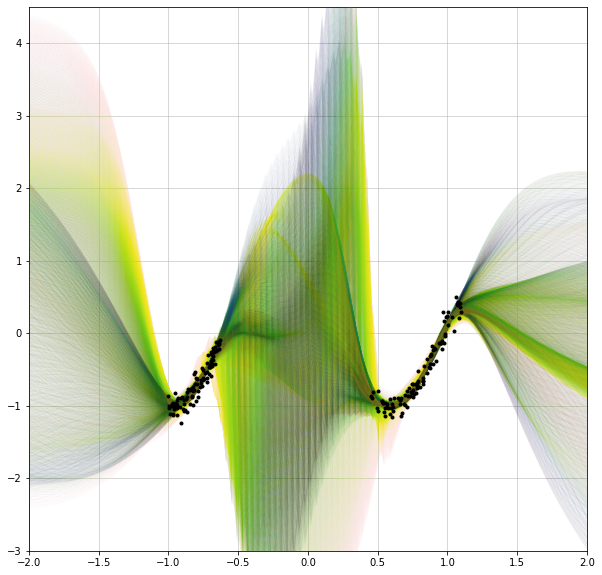

In [11]:
if setup.plot:
    fig=makePlot(setup,GeN,noise, alpha=0.01)


In [12]:
Z=[]

for i in range(colors.shape[0]):
    for j in range(colors.shape[1]):
        xy_noise=torch.Tensor([noise[0][i,j],noise[1][i,j]]).unsqueeze(0).to(device)
        Z.append(GeN.components[0].hnet(xy_noise).detach().squeeze(0))

In [13]:
Z=torch.stack(Z)
Z.shape

torch.Size([14400, 151])

In [14]:

C=[]
for i in range(colors.shape[0]):
    for j in range(colors.shape[1]):
        C.append(colors[i,j])

In [15]:
colors_stack=torch.stack(C)

In [16]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=3,init='pca',perplexity=100)
X_embedded =myTSNE.fit_transform(Z.cpu())
print(myTSNE.kl_divergence_)
X_embedded.shape

0.5311658382415771


(14400, 3)

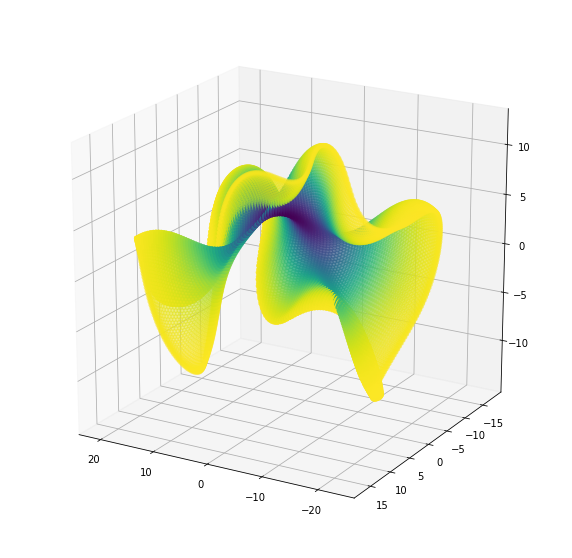

In [20]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


fig = plt.figure(figsize=(10, 10))


cmap = cm.viridis_r
ax = fig.gca(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2], c=colors_stack, linewidth=0.2, cmap=cmap)
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
ax.view_init(elev=20., azim=120)
plt.savefig('tSNE.pdf')
plt.show()





In [21]:
GeNVI_theta=GeN(1110).detach()

In [5]:
PTMCMC_theta=torch.load('mlruns/4/0eb6f8d414d1424784fa76fed8506198/artifacts/theta.pt')
#'mlruns/4/814abccf119b4eb1a0f68c1f67dc773f/artifacts/theta.pt')
#'mlruns/4/74654e3a649f4f47a71234edee2e4424/artifacts/theta.pt')[0:-1:1]


In [6]:
PTMCMC_theta.shape

torch.Size([1111, 151])

In [7]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=3,init='pca',perplexity=20)
X_embedded =myTSNE.fit_transform(PTMCMC_theta.cpu())
print(myTSNE.kl_divergence_)
X_embedded.shape

0.058706287294626236


(1111, 3)

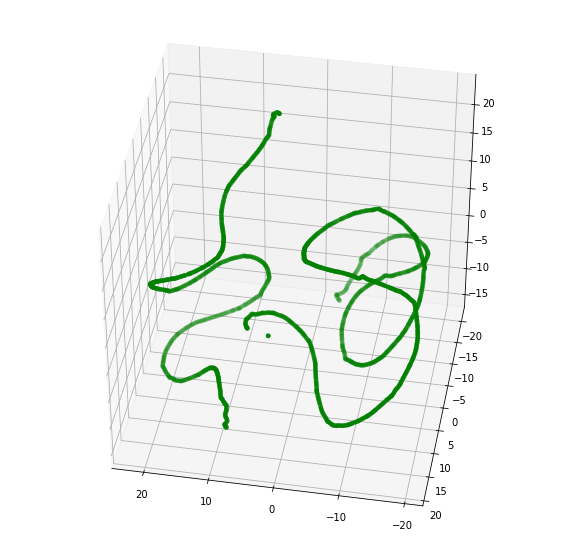

In [8]:
%matplotlib inline


from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2], linewidth=0.2, color='green')
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')

ax.view_init(elev=40., azim=100)
plt.savefig('PTMCMC_tSNE.pdf')
plt.show()


In [26]:
def KL(theta0,theta1,k=1):
        """
        Parameters:
            theta0 (Tensor): Samples, P X NbDimensions   
            theta1 (Tensor): Samples, R X NbDimensions   
            k (Int): positive ordinal number 

        Returns:
            (Float) k-Nearest Neighbour Estimation of the KL from theta0 to theta1  

        Kullback-Leibler Divergence Estimation of Continuous Distributions Fernando Pérez-Cruz
        """
        
        n0=theta0.shape[0]
        n1=theta1.shape[0]
        dim0=theta0.shape[1]
        dim1=theta1.shape[1]
        assert dim0 == dim1
        
   
        
        D0=torch.cdist(theta0,theta0)
        D1=torch.cdist(theta0,theta1)
        

        a0 = torch.topk(D0, k=k+1, dim=1, largest=False, sorted=True)[0][:,k]#.clamp(torch.finfo().eps,float('inf')).to(device)
        a1 = torch.topk(D1, k=k, dim=1, largest=False, sorted=True)[0][:,k-1]#.clamp(torch.finfo().eps,float('inf')).to(device)
        
        assert a0.shape == a1.shape
        
        d=torch.as_tensor(float(dim0),device=device)
        N0=torch.as_tensor(float(n0),device=device)
        N1=torch.as_tensor(float(n1),device=device)
        
        Mnn=(torch.log(a1)-torch.log(a0)).mean()
        return dim0*Mnn + N1.log()-(N0-1).log()

In [27]:
N=1000
K=torch.Tensor(N)
P_theta=PTMCMC_theta.to(device)
indices=list(range(P_theta.shape[0]))

for i in range(N):
    np.random.shuffle(indices)
    K[i]=KL(GeN(500).detach(),P_theta[indices[500:]], k=2)

print('KL: '+str(K.mean())+' ('+str(K.std())+')')

KL: tensor(509.8349) (tensor(3.8990))


In [28]:
N=1000
K=torch.Tensor(N)
P_theta=PTMCMC_theta.to(device)
indices=list(range(P_theta.shape[0]))

for i in range(N):
    np.random.shuffle(indices)
    K[i]=KL(P_theta[indices[500:]],GeN(500).detach(), k=2)

print('KL: '+str(K.mean())+' ('+str(K.std())+')')

KL: tensor(572.1548) (tensor(2.8588))


In [29]:
N=1000
K=torch.Tensor(N)
P_theta=PTMCMC_theta.to(device)
indices=list(range(P_theta.shape[0]))

for i in range(N):
    np.random.shuffle(indices)
    K[i]=KL(GeN(500).detach(),GeN(500).detach(), k=2)

print('KL: '+str(K.mean())+' ('+str(K.std())+')')

KL: tensor(-0.3392) (tensor(4.3445))


In [30]:
X=torch.arange(-2.,2.,0.03).to(device)

In [31]:
N=1000
K=torch.Tensor(N)
P_theta_pred=model(X,PTMCMC_theta.to(device)).squeeze()
indices=list(range(P_theta.shape[0]))

for i in range(N):
    np.random.shuffle(indices)
    GeNVI_pred=model(X,GeN(500).detach()).squeeze()
    K[i]=KL(GeNVI_pred,P_theta_pred[indices[500:]], k=2)

print('KL: '+str(K.mean())+' ('+str(K.std())+')')

KL: tensor(175.0446) (tensor(3.5762))


In [32]:
N=1000
K=torch.Tensor(N)
P_theta_pred=model(X,PTMCMC_theta.to(device)).squeeze()
indices=list(range(P_theta.shape[0]))

for i in range(N):
    np.random.shuffle(indices)
    GeNVI_pred=model(X,GeN(500).detach()).squeeze()
    K[i]=KL(P_theta_pred[indices[500:]],GeNVI_pred, k=2)

print('KL: '+str(K.mean())+' ('+str(K.std())+')')

KL: tensor(314.3816) (tensor(4.3012))


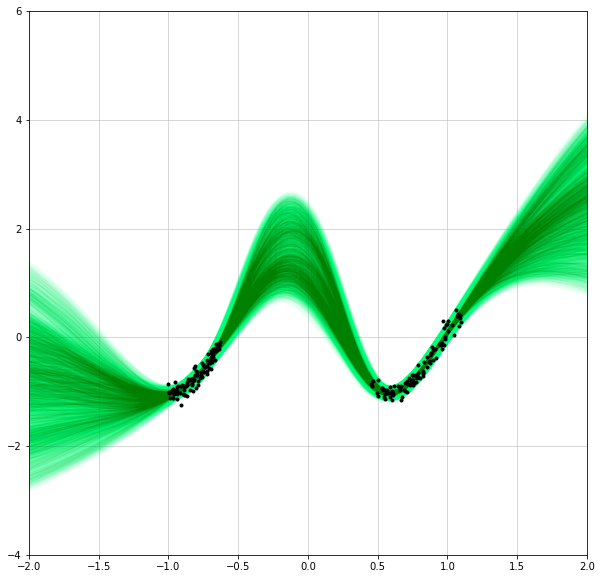

In [80]:
x=setup.makePlot(PTMCMC_theta,device)
x.savefig('PTMCMC_green_pred.png')


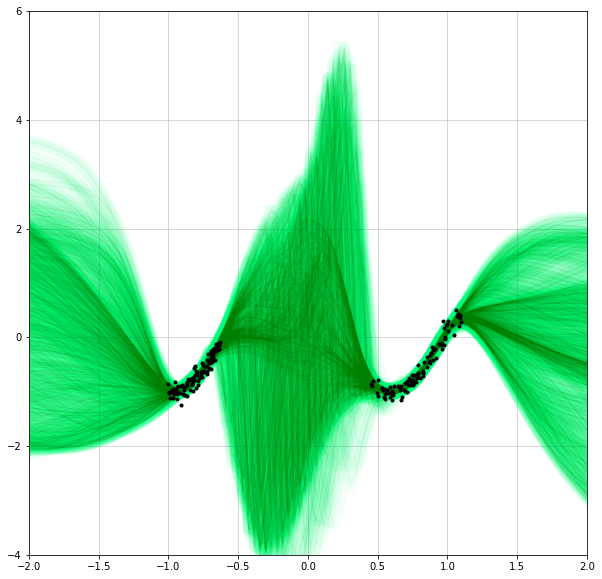

In [33]:
fig=setup.makePlot(GeNVI_theta,device)
fig.savefig('GeNVI_green_pred.svg')

In [34]:
N=PTMCMC_theta.shape[0]
GeNVI_pred=model(X,GeN(N).detach()).squeeze()
PTMCMC_pred=model(X,PTMCMC_theta.to(device)).squeeze()
theta_pred=torch.cat([GeNVI_pred, PTMCMC_pred])
c=torch.cat([torch.zeros(N), torch.ones(N)])
theta_pred.shape

torch.Size([2222, 134])

In [35]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=3,init='pca',perplexity=35)
X_embedded_pred =myTSNE.fit_transform(theta_pred.cpu())
print(myTSNE.kl_divergence_)
X_embedded.shape

0.5591526627540588


(1111, 3)

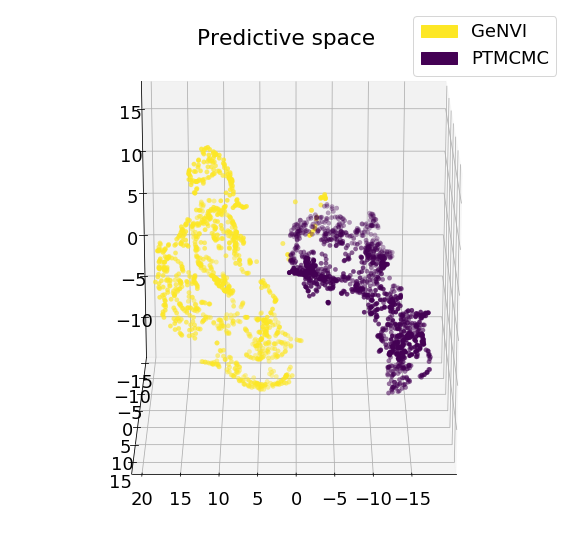

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})


fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(X_embedded_pred[:,0],X_embedded_pred[:,1],X_embedded_pred[:,2],c=c, linewidth=0.2, cmap=cmap)
plt.title('Predictive space')
ax.view_init(elev=20., azim=90)


GeNVI_patch = mpatches.Patch(color=cmap(0.), label='GeNVI')
PTMCMC_patch = mpatches.Patch(color=cmap(1.), label='PTMCMC')
plt.legend(handles=[GeNVI_patch,PTMCMC_patch])
plt.savefig('Predictive_tSNE.pdf')
plt.show()

In [37]:
theta=torch.cat([GeN(N).detach(), PTMCMC_theta.to(device)])
theta.shape

torch.Size([2222, 151])

In [38]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=3,init='pca',perplexity=100)
X_embedded =myTSNE.fit_transform(theta.cpu())
print(myTSNE.kl_divergence_)
X_embedded.shape

0.13300524652004242


(2222, 3)

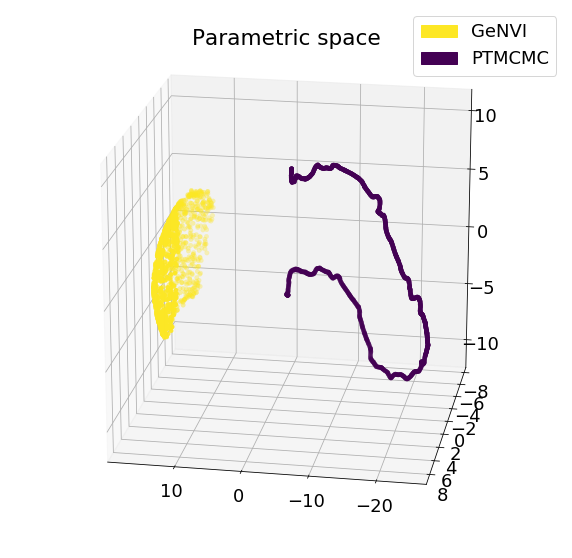

In [39]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 18})


fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2],c=c, linewidth=0.2, cmap=cmap)
plt.title('Parametric space')

ax.view_init(elev=20., azim=100)

GeNVI_patch = mpatches.Patch(color=cmap(0.), label='GeNVI')
PTMCMC_patch = mpatches.Patch(color=cmap(1.), label='PTMCMC')
plt.legend(handles=[GeNVI_patch,PTMCMC_patch])

plt.savefig('Parametric_tSNE.pdf')
plt.show()



Text(0.5, 1.0, '134 vs 73')

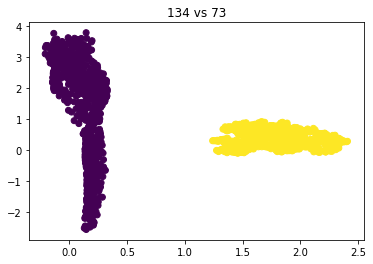

In [59]:
%matplotlib inline
i=np.random.randint(0,theta.shape[1])
j=np.random.randint(0,theta.shape[1])
X=theta[:,i].cpu()
Y=theta[:,j].cpu()
plt.scatter(X,Y, c=c)
plt.title(str(i)+' vs '+str(j))